# *Projection-Free Kernel Principal Component Analysis (PFKPCA) for the MNIST data set*
#### *A.T. Bui, J.-K. Im and D.W. Apley et al. / Neurocomputing 357 (2019) 163–176*

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines

import pfkpca as pf

## *Read the MNIST data for number 8*
---

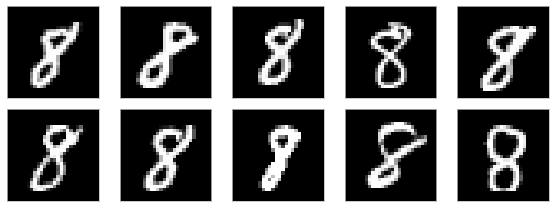

In [2]:
img = pf.read_mnist_data('./data8')
n_rows, n_cols = 2, 5 
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8,n_rows*1.5))
for i in range(1,n_rows+1):
    for j in range(1,n_cols+1):
        idx = i*j-1+(i-1)*(n_cols-1)
        ax[i-1,j-1].imshow(img[idx], cmap='gist_gray')
        ax[i-1,j-1].set(xticks=[], yticks=[])
plt.tight_layout()

## *Add noise*
---

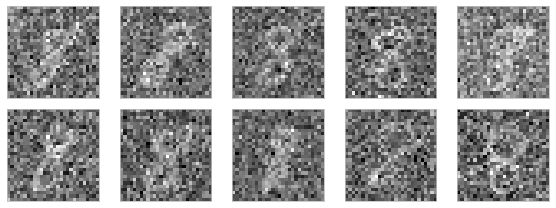

In [3]:
np.random.seed(0)

N, px, py = img.shape
mu, sigma = 0, 2

noisy_img = np.zeros_like(img)
for i in range(len(img)):
    noise = np.random.normal(loc=mu, scale=sigma, size=(px,py))
    noisy_img[i] = img[i] + noise
    
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8,n_rows*1.5))
for i in range(1,n_rows+1):
    for j in range(1,n_cols+1):
        idx = i*j-1+(i-1)*(n_cols-1)
        ax[i-1,j-1].imshow(noisy_img[idx], cmap='gist_gray')
        ax[i-1,j-1].set(xticks=[], yticks=[])
plt.tight_layout()

## *Run PFKPCA to denoise the images*

*__Note:__ show_proj, show_gradescent*, and *show_denoised* functionality are only implemented for the synthetic quadratic dataset used in the toy example (see [pfkpca_toy.ipynb](./pfkpca_toy.ipynb)).

They must be set to *False* for the MNIST or any other dataset.

---

In [4]:
n = N
noisy_data = noisy_img[:n].reshape(n,-1).T
denoised_data, kpca_res, descend_dir, z_star = pf.pfkpca(noisy_data, L=5, kernel='rbf', rho_m=1.0, 
                                                         show_proj=False, show_gradescent=False, show_denoised=False, 
                                                         verb=True)

true_data = img.reshape(N,-1).T
r1 = pf.r1(denoised_data[:,:n], noisy_data[:,:n], true_data[:,:n], verb=True)

PFKPCA: Step 0 - Perform KPCA...


PFKPCA: Step 1 - Find the direction of the steepest descend: 100%|██████████| 1000/1000 [01:13<00:00, 13.60img/s]
PFKPCA: Step 2 & 3 - Denoise the data: 100%|██████████| 1000/1000 [16:25<00:00,  1.01img/s]



PFKPCA: Step 0 - Perform KPCA took 5.7999 seconds
PFKPCA: Step 1 - Direction of the steepest descend took 73.5709 seconds
PFKPCA: Step 2 & 3 - Denoise the data took 985.6088 seconds
PFKPCA took 1064.9799 seconds

PFKPCA: Denoising performance measure 
	 r1 = 0.33427587332666314


## *Compare the original, noisy, and denoised images*
---

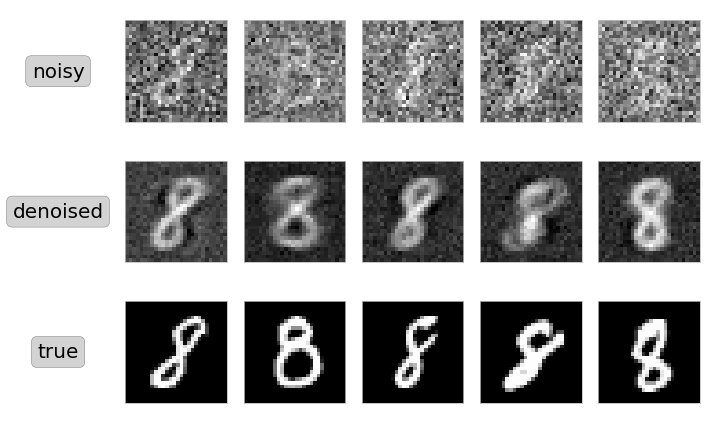

In [5]:
denoised_img = denoised_data.T.reshape(-1,px,py)
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(10,6))

texts = ['noisy', 'denoised', 'true']
for i in range(len(texts)):
    ax[i,0].text(.5, .5, texts[i], size=20, 
                 ha='center', va='center',
                 bbox=dict(boxstyle='round', ec='gray', fc='lightgray'))
    ax[i,0].axis('off')

n_eg = 5
egs = np.random.randint(0, n, n_eg)
for i in range(len(egs)):
    eg = egs[i]
    i += 1
    ax[0,i].imshow(noisy_img[eg], cmap='gist_gray')
    ax[0,i].set(xticks=[], yticks=[])
    ax[1,i].imshow(denoised_img[eg], cmap='gist_gray')
    ax[1,i].set(xticks=[], yticks=[])
    ax[2,i].imshow(img[eg], cmap='gist_gray')
    ax[2,i].set(xticks=[], yticks=[])
plt.tight_layout()

## *Plot $g(\alpha)$ vs $\alpha$ (Fig. 15 of A.T. Bui et al. / Neurocomputing 357 (2019) 163–176)*
---

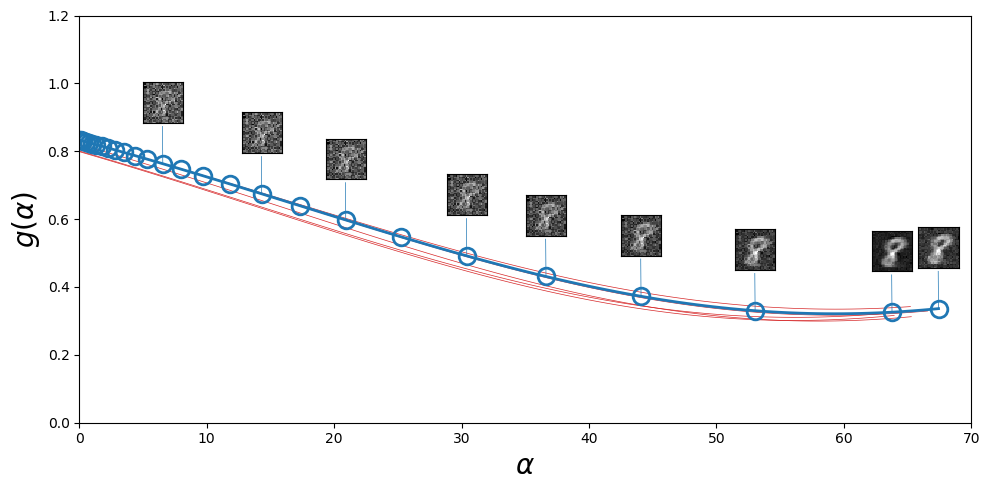

In [6]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10,5))

d = descend_dir
alphas = kpca_res['alphas']
rho = kpca_res['rho']
centering_params = kpca_res['centering_params']

idx = egs
for i in range(len(idx)):
    z_init = noisy_data.T[idx[i]]

    ## Find an interval (0, A) for the steps 
    x_dot_d = noisy_data.T.dot(d[idx[i]])           
    x_dot_di = x_dot_d[idx[i]]                        
    A = np.delete(x_dot_d, idx[i]).max() - x_dot_di

    xaxis = np.linspace(0.0, A, num= 100)           ## Evenly spaced steps in interval (0,A)
    Z = np.array([z_init + alpha * d[idx[i]] for alpha in xaxis]) ## Find z for each step in interval
    
    ## Find the cost for each z
    yaxis = np.array([pf.cost_rbf(z, noisy_data, alphas, rho, centering_params) for z in Z]).squeeze()
    ax.plot(xaxis, yaxis, color='tab:red', linewidth=0.5)
    
## g(alpha) vs alpha for a particular img, i.e Img[idx]
idx = 50
z_init = noisy_data.T[idx] 
x_dot_d = noisy_data.T.dot(d[idx])           
x_dot_di = x_dot_d[idx]                        
A = np.delete(x_dot_d, idx).max() - x_dot_di
xaxis = np.linspace(0.0, A, num=100) 
Z = np.array([z_init + alpha * d[idx] for alpha in xaxis])
yaxis = np.array([pf.cost_rbf(z, noisy_data, alphas, rho, centering_params) for z in Z]).squeeze()
ax.plot(xaxis, yaxis, color='tab:blue', linewidth=2)

## g(alpha) vs alpha for the real step sizes for a particular img, i.e Img[idx]
step = [0]                                 
j = 0                                      
I = 500
h = 1.2
while step[j] < A:                         
    step_next = step[j] + (A * (h**j))/(I - 1) 
    step.append(step_next)
    j = j + 1                              
step [-1] = A 
steps = np.array(step)
Z2 = np.array([z_init + alpha * d[idx] for alpha in steps])
yaxis = np.array([pf.cost_rbf(z, noisy_data, alphas, rho, centering_params) for z in Z2]).squeeze()
ax.plot(steps, yaxis, ls='', markeredgewidth=2, marker='o', markersize=12, markerfacecolor='none', color='tab:blue')
ax.set_xlim(0,70)
ax.set_ylim(0,1.2)

## Denoise an img. at particular alphas

step_rs = steps/70                      ## Rescale axes to (0,1)
yaxis_rs = yaxis/1.2
index = np.array([-1, -2, -3, -4, -5, -6, -8, -10, -14]) ## Index of alphas & g(alpha)s
for i in index:
    left = step_rs[i]
    bottom = yaxis_rs[i]
    shift_x = 0.025                     ## Shift images towards the middle of the dots on x axis
    shift_y = 0.1                     ## Shift images upwards on y axis
    inset = ax.inset_axes([left-shift_x, bottom+shift_y, .05, .1], transform=ax.transAxes)## Positions of the img.s to insert

## Find the denoised img. at a particular alpha value
    z = Z2[i]
    d_cost = pf.grad_cost_rbf(z_star, noisy_data, alphas, rho, centering_params).dot(d[idx])
    

    if d_cost < 0:
        xi_hat = z_init + 0.5 * (steps[i-1] + steps[i]) * d[idx] 
    elif d_cost == 0:
        xi_hat = z_init + steps[i-1] * d[idx]
    else:
        xi_hat = z_init + 0.5 * (steps[i-2] + steps[i-1]) * d[idx]
        
    
    denoised_image = xi_hat.reshape(px,py)           ## Imshow takes (px,py) dim. input
    #print(denoised_image.shape)
    
    inset.imshow(denoised_image, cmap='gist_gray')   ## Insert denoised img.s at particular alphas
    inset.set(xticks=[], yticks=[])                  ## Remove grids from the img.s

    ## Draw the lines from alphas to img.s
    X = [steps[i], steps[i]-shift_x]                 ## X-coord.s of the alphas & middle of the img.s
    Y = [yaxis[i], yaxis[i]+1.1*shift_y]             ## Y-coord of the alphas & the bottom of the img.s
    line = lines.Line2D(X, Y, ls='-', lw=.5, color='tab:blue')
    ax.add_line(line)
ax.set_xlabel(xlabel=r'$\alpha$', fontsize=20)
ax.set_ylabel(ylabel=r'$g(\alpha)$', fontsize=20)

plt.tight_layout()